<a href="https://colab.research.google.com/github/Surya291/WiFi_Sensing_2.0/blob/master/Code/Expt2/exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import sys
import json
import argparse
import pandas as pd
import numpy as np
import scipy.signal as signal
from sklearn import decomposition, preprocessing  
from mpl_toolkits.mplot3d import Axes3D  
import cv2
import matplotlib.pyplot as plt
from numba import jit

In [7]:
df  = pd.read_csv('walking.csv')
print(df.columns)

Index(['type', 'role', 'mac', 'rssi', 'rate', 'sig_mode', 'mcs', 'bandwidth',
       'smoothing', 'not_sounding', 'aggregation', 'stbc', 'fec_coding', 'sgi',
       'noise_floor', 'ampdu_cnt', 'channel', 'secondary_channel',
       'local_timestamp', 'ant', 'sig_len', 'rx_state', 'real_time_set',
       'real_timestamp', 'len', 'CSI_DATA'],
      dtype='object')


      rssi
0      -43
1      -43
2      -46
3      -46
4      -46
...    ...
5800   -54
5801   -54
5802   -54
5803   -51
5804   -51

[5805 rows x 1 columns]
      real_timestamp
0           0.311965
1           0.327260
2           0.332001
3           0.347290
4           1.192904
...              ...
5800       75.523904
5801       75.527631
5802       75.531365
5803       75.535121
5804       75.538691

[5805 rows x 1 columns]


Text(0, 0.5, 'rssi magnitude')

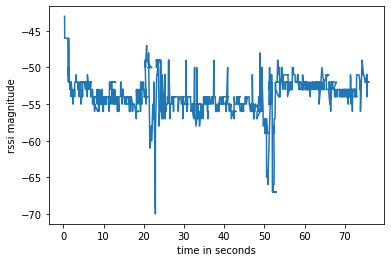

In [17]:
df_rssi = df.loc[:,['rssi']]
df_time = df.loc[:, ['real_timestamp']]
print(df_rssi)
print(df_time)
#df_rssi.plot(y=['rssi'])
#plt.axis([0, len(df_rssi.index), -72, -45])
plt.plot(df_time['real_timestamp'], df_rssi['rssi'])
plt.xlabel('time in seconds')
plt.ylabel('rssi magnitude')

In [18]:
df_csi = df.loc[:, ['len', 'CSI_DATA']]
drop_idx = []
for i in range(df_csi.shape[0]):
  if df_csi.iloc[i]['len'] < 384:
    drop_idx.append(i)

df_csi = df_csi.drop(drop_idx)
size_x = len(df_csi.index)
size_y = df_csi.iloc[0]['len']//2 # no. of subcarriers ..

array_csi = np.zeros([size_x, size_y], dtype = np.complex64)

for x , csi in enumerate(df_csi.iloc):
    temp = csi["CSI_DATA"].replace(' ', ',')
    temp = temp.replace(',]', ']')
    csi_raw_data = json.loads(temp)
    for y in range(0, len(csi_raw_data), 2):
        array_csi[x][y//2] = complex(csi_raw_data[y], csi_raw_data[y + 1])  # IQ channel frequency response



In [19]:
size_y

192

In [22]:
time_0 = df_time.iloc[0]['real_timestamp']
time_n = df_time.iloc[-1]['real_timestamp']
print(time_n)

75.538691


(5800, 192)
140


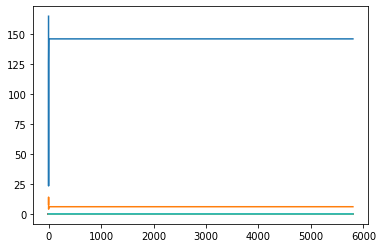

In [30]:
array_csi_modulus = abs(array_csi)  # amplitude calculating
print(array_csi_modulus.shape)

drop_idx = [0, 1]

for i in range(array_csi_modulus.shape[1]):
  if (np.var(array_csi_modulus[:, i]) < 1e-3):
    drop_idx.append(i)



print(len(drop_idx))

for i in (drop_idx):
  plt.plot(array_csi_modulus[:, i])

#Only 52 sub-carriers have meaning full data

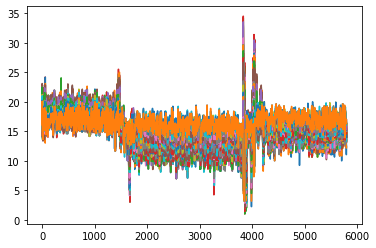

In [43]:
select_list = [i for i in range(array_csi_modulus.shape[1])]

for i in drop_idx:
  select_list.remove(i)

columns = [i for i in range(0, size_y)]
df_csi_modulus = pd.DataFrame(array_csi_modulus, columns=columns)

df_csi_modulus.plot(y = [i for i in select_list], legend=False)

plt.show()

In [14]:
@jit(nopython=True)
def hampel_filter(input_series, window_size, n_sigmas=3):
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    indices = []
    
    for i in range((window_size),(n - window_size)):
        x0 = np.nanmedian(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.nanmedian(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices



In [46]:
df_csi_modulus= (df_csi_modulus.drop(drop_idx, axis=1))
print(df_csi_modulus.columns)

In [49]:
print(df_csi_modulus)

             6          7          8   ...         56         57         58
0     17.117243  17.117243  18.248287  ...  18.110771  17.464249  17.117243
1     18.000000  19.026299  20.000000  ...  21.000000  20.223749  20.099751
2     16.000000  16.031219  17.029387  ...  16.000000  16.124516  16.031219
3     18.384777  17.088007  19.313208  ...  17.492855  17.464249  17.000000
4     17.262676  16.278820  17.262676  ...  16.000000  16.124516  16.031219
...         ...        ...        ...  ...        ...        ...        ...
5795  11.045361  12.165525  14.035668  ...  16.031219  17.000000  17.000000
5796  11.045361  12.165525  14.035668  ...  16.031219  17.000000  17.000000
5797  11.045361  12.165525  14.035668  ...  16.031219  17.000000  17.000000
5798  12.649111  12.369317  13.341664  ...  16.492422  16.278820  16.278820
5799  12.649111  12.369317  13.341664  ...  16.492422  16.278820  16.278820

[5800 rows x 52 columns]


In [48]:
print(df_csi_modulus.shape)
csi_mod = df_csi_modulus['']

(5800, 52)


In [47]:
for i in df_csi_modulus.columns:
  tmp = df_csi_modulus['']

Int64Index([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
            23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40,
            41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
            58],
           dtype='int64')
